In [10]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from pyuoi.linear_model import UoI_L1Logistic
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
gp_path = '/Users/psachdeva/data/berkes/IM-1015_170520_GP_rates_v4.mat'
snr_path = '/Users/psachdeva/data/berkes/IM-1015_170520_SNr_rates_v4.mat'

In [3]:
gp = loadmat(gp_path, struct_as_record=False)
snr = h5py.File(snr_path, 'r')

# Predicting pre-tone failure

In [60]:
trials = gp['Trials'][0]
good_trials = np.arange(trials.size)
good_trials = np.delete(good_trials, [0, 250])
n_trials = good_trials.size

good_units = np.array([4,5,6,7,8,9,12,13,14,15,16,17,18,19,20,25,26,27]) - 1
n_units = good_units.size

In [74]:
success_delays = np.array([])
failure_delays = np.array([])

for t_idx, trial_idx in enumerate(good_trials):
    trial = trials[trial_idx]
    center_in_t = np.asscalar(trial.CenterInEvent)
    center_out_t = np.asscalar(trial.CenterOutEvent)
    if trial.Evt[0, 0].Cond - 1 == 1:
        success_delays = np.append(success_delays, center_out_t - center_in_t)
    elif trial.Evt[0, 0].Cond - 1 == 0:
        failure_delays = np.append(failure_delays, center_out_t - center_in_t)


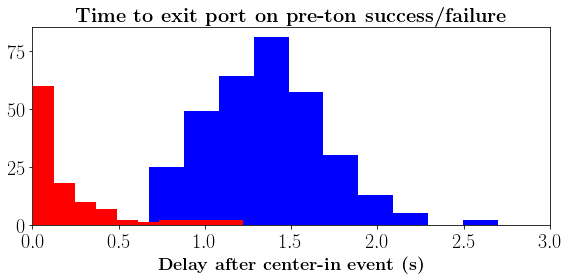

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(success_delays, color='b')
ax.hist(failure_delays, color='r')
ax.set_xlim([0, 3])
ax.set_xlabel(r'\textbf{Delay after center-in event (s)}', fontsize=18)
ax.set_title(r'\textbf{Time to exit port on pre-ton success/failure}', fontsize=20)
plt.tight_layout()
plt.savefig('delay.pdf')

In [76]:
delays = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
n_delays = delays.size
n_folds = 5
scores = np.zeros((n_delays, n_folds))
coefs = np.zeros((n_delays, n_folds, X_new.shape[1]))

In [77]:
for delay_idx, delay in enumerate(delays):
    print(delay_idx)
    X = np.zeros((n_trials, n_units))
    y = np.zeros(n_trials)

    for t_idx, trial_idx in enumerate(good_trials):
        trial = trials[trial_idx]
        # get trial label
        y[t_idx] = trial.Evt[0, 0].Cond - 1

        # get cue times
        center_cue_t = np.asscalar(trial.CenterCueEvent)
        center_in_t = np.asscalar(trial.CenterInEvent)

        for u_idx, unit_idx in enumerate(good_units):
            unit = trial.Units[0, unit_idx]

            spike_times = unit.spkTimes
            spike_count = np.count_nonzero(
                (spike_times >= center_in_t) & (spike_times <= center_in_t + 1)
            )
            X[t_idx, u_idx] = spike_count

    scaler = StandardScaler()
    X_new = scaler.fit_transform(X)

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    skf.get_n_splits(X_new, y)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_new, y)):
        logistic = LogisticRegressionCV(
            Cs=100, fit_intercept=True, cv=10,
            penalty='l1', solver='saga',
            max_iter=5000
        )
        logistic.fit(X_new[train_idx, :], y[train_idx])
        coefs[delay_idx, fold] = logistic.coef_
        scores[delay_idx, fold] = logistic.score(X_new[test_idx, :], y[test_idx])

0
1
2
3
4
5
6
7
8
9


In [78]:
chance = np.count_nonzero(y)/y.size

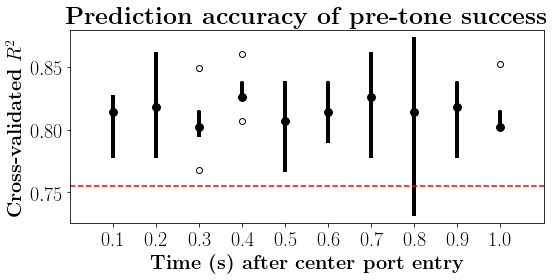

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.boxplot(
    x=scores.T,
    positions=delays,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'},
)
ax.set_xlim([0.0, 1.1])
ax.axhline(chance, color='r', linestyle='--')
ax.set_xlabel(r'\textbf{Time (s) after center port entry}', fontsize=20)
ax.set_ylabel(r'\textbf{Cross-validated} $R^2$', fontsize=20)
ax.set_title(r'\textbf{Prediction accuracy of pre-tone success}', fontsize=25)
plt.tight_layout()
plt.savefig('gp1.pdf')
plt.show()

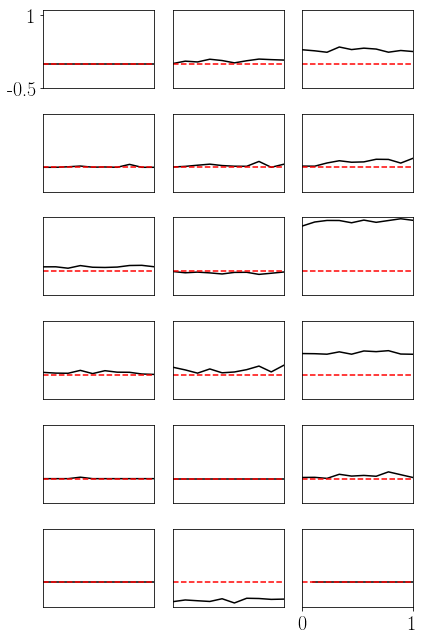

In [129]:
medians = np.median(coefs, axis=1)

fig, axes = plt.subplots(6, 3, figsize=(6, 9))
for idx, ax in enumerate(axes.ravel()):
    ax.plot(delays, medians[:, idx], color='k')
    ax.set_xlim([0.1, 1])
    ax.set_ylim([-0.5, 1.1])
    ax.axhline(0, color='r', linestyle='--')
    ax.set_xticks([])
    ax.set_yticks([])
axes[-1, -1].set_xticks([0, 1])
axes[-1, -1].set_xticklabels([0, 1])
axes[0, 0].set_yticks([-0.5, 1])
axes[0, 0].set_yticklabels([-0.5, 1])
plt.tight_layout()
plt.savefig('coefs.pdf')
plt.show()

array([0.92558402, 1.00682164, 1.03887556, 1.03773445, 0.99130134,
       1.04613876, 1.00041098, 1.03707451, 1.07366102, 1.04141998])